# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made
# TODO: figure out the units in COSMED

In [1]:
import numpy as np
import argparse

import os
import math
from math import sin

import pandas as pd
from sklearn.linear_model import LinearRegression


import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from TimeStampReader import *
from stage1_cosmed import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='sub101')
parser.add_argument('--filter_window', type=int, metavar='filter_window', help='filter_window',
                    default='5')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/raw/', 
                          '--output_folder', '../../data/stage1/',
                          '--subject_id', 'sub104',
                          '--filter_window', '5',
                         ])
# args = parser.parse_args()
print(args)

Namespace(filter_window=5, input_folder='../../data/raw/', output_folder='../../data/stage1/', subject_id='sub104')


In [3]:
inputdir = args.input_folder
outputdir = args.output_folder
subject_id = args.subject_id
filter_window = args.filter_window

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id+'/cosmed/'

if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)

In [4]:
if filter_window==1:
    outputdir_sub = outputdir_sub.replace('cosmed', 'cosmed_unfiltered')


In [5]:
# if 'unfiltered' in outputdir_sub:
#     filter_window = 1
# else:
#     filter_window = 5



In [6]:
outputdir_sub

'../../data/stage1/sub104/cosmed/'

In [7]:
import os

for subdir, dirs, files in os.walk(inputdir):
#     print(subdir, dirs, files)
    for dir_one in dirs:
        if subject_id in dir_one:
            inputdir_sub = inputdir + dir_one + '/'

In [8]:
inputdir_sub

'../../data/raw/sub104/'

In [9]:
#     fileName = inputdir_sub + 'sub005_121321/TEST_NO_80.csv'
#     fileName = inputdir + 'sub004_121021/TEST_NO_79.csv'

In [10]:
# subject_id = 'sub005'

for filename in os.listdir(inputdir_sub):
    if 'TEST' in  filename:
        if '.csv' in  filename:
#     print(filename)

            cosmed_filePath = inputdir_sub + filename
#     fileName = inputdir + 'sub004_121021/TEST_NO_79.csv'
    # fileName = inputdir + 'sub003_112321/TEST_NO_28.csv'

#     subject_id = 'sub'+fileName.split('sub')[1].split('_')[0]
cosmed_filePath

'../../data/raw/sub104/TEST_NO_89.csv'

In [11]:
for filename in os.listdir(inputdir_sub):
    if 'tm_backup' in  filename:
        if 'processed' in filename:
            print(filename)
            tm_filePath = inputdir_sub + filename


tm_backup_0103_sub104_processed.txt


In [12]:
tm_filePath

'../../data/raw/sub104/tm_backup_0103_sub104_processed.txt'

# read timestamps, use readTimeStampData to parse data

In [13]:
ts_dict = readTimeStampData(tm_filePath, dateBegin=None, dateEnd=None)

df_timestamps = pd.DataFrame(ts_dict, columns=['datetime', 'note'])
df_timestamps = df_timestamps.sort_values(by=['datetime'], ascending=True)


# create the timestamps dictionary

In [14]:
def ts2sec(df_timestamps, task_name, ith_taskname):
    """
        this function provides the name of the task and the time in sec of the labeled task
        TODO: provide documentation

    """
    datetime = df_timestamps[df_timestamps['note']==task_name].reset_index(drop=True).iloc[ith_taskname]['datetime']
    seconds = datetime.timestamp()
    
    task_renamed = task_name+' '+str(ith_taskname)
    
    return task_renamed, seconds


In [15]:
task_ts_dict = {}

for task_name in df_timestamps['note'].unique():
    N_rows = df_timestamps[df_timestamps['note']==task_name].shape[0]

    for ith_taskname in range(N_rows):
        task_renamed, time_in_s = ts2sec(df_timestamps, task_name, ith_taskname)
        task_ts_dict[task_renamed] = time_in_s

t_start = task_ts_dict['3 Taps 0']
for key in task_ts_dict:
    task_ts_dict[key] = task_ts_dict[key] - t_start

In [16]:
task_ts_dict

{'Device Sync watch 0': -1540.1200001239777,
 'Device Sync [0095] sternum 0': -1418.590000152588,
 'Device Sync [0202] clavicle 0': -1394.6600000858307,
 'Device Sync [0022] ribcage 0': -1373.6100001335144,
 '0095 sternum placed 0': -1002.3300001621246,
 'Seismowatch on 0': -826.2700002193451,
 'Cosmed Recording On 0': -72.70000004768372,
 '3 Taps 0': 0.0,
 'Start Baseline 0': 70.85999989509583,
 'End Baseline 0': 250.4799997806549,
 'Start Standing 0': 262.539999961853,
 'End Standing 0': 322.25999999046326,
 'Start Proning 0': 342.89999985694885,
 'End Proning 0': 402.96999979019165,
 'Start LL 0': 413.6799998283386,
 'End LL 0': 474.32999992370605,
 'Start LR 0': 485.6799998283386,
 'End LR 0': 546.5499999523163,
 'Start Cough 0': 576.6299998760223,
 'Start Cough 1': 3239.9199998378754,
 'End Cough 0': 582.1599998474121,
 'End Cough 1': 3244.689999818802,
 'Start SpeakCasual 0': 616.1399998664856,
 'Start SpeakCasual 1': 3355.0199999809265,
 'End SpeakCasual 0': 677.9899997711182,
 

In [17]:
# df_cosmed

In [18]:
# #         df_data = df_cosmed[df_cosmed[df_cosmed[0]=='IDS'].index[0]:] # the 0~25 rows are not timeseries data


# get cosmed data

In [19]:
df_cosmed = pd.read_csv(cosmed_filePath, header=None, sep='\n')
df_cosmed = df_cosmed[0].str.split(',', expand=True)
df_cosmed[:30]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,# Type Time Date Duration ...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,89 BxB 11:48:25 2022/01/03 01:28:11 ...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,filename: /mnt/archive/tests/58f48032-ea65-436...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,UUD,120,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Test type,BxB,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,Test no.,89,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Duration,01:28:11,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Items,1994,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,BTPS,11009,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,BTPSE,10202,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [20]:
task_ts_dict

{'Device Sync watch 0': -1540.1200001239777,
 'Device Sync [0095] sternum 0': -1418.590000152588,
 'Device Sync [0202] clavicle 0': -1394.6600000858307,
 'Device Sync [0022] ribcage 0': -1373.6100001335144,
 '0095 sternum placed 0': -1002.3300001621246,
 'Seismowatch on 0': -826.2700002193451,
 'Cosmed Recording On 0': -72.70000004768372,
 '3 Taps 0': 0.0,
 'Start Baseline 0': 70.85999989509583,
 'End Baseline 0': 250.4799997806549,
 'Start Standing 0': 262.539999961853,
 'End Standing 0': 322.25999999046326,
 'Start Proning 0': 342.89999985694885,
 'End Proning 0': 402.96999979019165,
 'Start LL 0': 413.6799998283386,
 'End LL 0': 474.32999992370605,
 'Start LR 0': 485.6799998283386,
 'End LR 0': 546.5499999523163,
 'Start Cough 0': 576.6299998760223,
 'Start Cough 1': 3239.9199998378754,
 'End Cough 0': 582.1599998474121,
 'End Cough 1': 3244.689999818802,
 'Start SpeakCasual 0': 616.1399998664856,
 'Start SpeakCasual 1': 3355.0199999809265,
 'End SpeakCasual 0': 677.9899997711182,
 

In [21]:
sub = Subject(df_cosmed, task_ts_dict, subject_id=subject_id)
sub.show_demographic()

task name       |	start time		  duration
Baseline 0      |	     70.86s		    179.62s
Standing 0      |	    262.54s		     59.72s
Proning 0       |	    342.90s		     60.07s
LL 0            |	    413.68s		     60.65s
LR 0            |	    485.68s		     60.87s
Cough 0         |	    576.63s		      5.53s
SpeakCasual 0   |	    616.14s		     61.85s
SpeakScripted 0 |	    709.18s		     59.07s
6MWT 0          |	   2345.34s		    358.97s
Recovery 0      |	   2077.20s		    180.79s
6MWT-R 0        |	   1700.26s		    359.73s
Recovery 1      |	   2717.48s		    180.94s
StairDown0 not in task_ts_dict
StairUp0 not in task_ts_dict
StairDown1 not in task_ts_dict
Recovery 2      |	   3061.75s		    186.60s
Cough 1         |	   3239.92s		      4.77s
SpeakCasual 1   |	   3355.02s		     69.51s
SpeakScripted 1 |	   3440.47s		     60.21s
Walk 0          |	   3621.74s		    353.06s
Recovery 3      |	   3985.57s		    180.46s
Run 0           |	   4226.14s		    137.50s
Recovery 4      |	   4373.90s		    179.12s
Exhausti

In [22]:
sub.task_ts_dict

{'Device Sync watch 0': -1540.1200001239777,
 'Device Sync [0095] sternum 0': -1418.590000152588,
 'Device Sync [0202] clavicle 0': -1394.6600000858307,
 'Device Sync [0022] ribcage 0': -1373.6100001335144,
 '0095 sternum placed 0': -1002.3300001621246,
 'Seismowatch on 0': -826.2700002193451,
 'Cosmed Recording On 0': -72.70000004768372,
 '3 Taps 0': 0.0,
 'Start Baseline 0': 70.85999989509583,
 'End Baseline 0': 250.4799997806549,
 'Start Standing 0': 262.539999961853,
 'End Standing 0': 322.25999999046326,
 'Start Proning 0': 342.89999985694885,
 'End Proning 0': 402.96999979019165,
 'Start LL 0': 413.6799998283386,
 'End LL 0': 474.32999992370605,
 'Start LR 0': 485.6799998283386,
 'End LR 0': 546.5499999523163,
 'Start Cough 0': 576.6299998760223,
 'Start Cough 1': 3239.9199998378754,
 'End Cough 0': 582.1599998474121,
 'End Cough 1': 3244.689999818802,
 'Start SpeakCasual 0': 616.1399998664856,
 'Start SpeakCasual 1': 3355.0199999809265,
 'End SpeakCasual 0': 677.9899997711182,
 

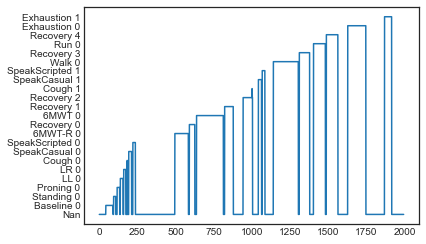

In [23]:
plt.plot(sub.df_data['task'])

# create a list of task names

In [24]:
# from setting
len(FS_tasks)

27

# inspect label (TBD)

In [25]:
def filter_df_cosmed(df_cosmed, outputdir=None, show_plot=False):
    cosmed_resampled = {}
    df_cosmed_filtered = df_cosmed.copy()
    
    variables_movingfile = ['HR', 'RR', 'VT', 'VE', 'VO2', 'VCO2', 'EE', 'SPO2', 'FiO2', 'FeO2', 'FiCO2', 'FeCO2', 'K5_R']
    variables_medfile = ['GpsAlt', 'AmbTemp', 'Battery']

    n_plots = len(variables_movingfile) + len(variables_medfile)

    fig, axes = plt.subplots(n_plots, 1, figsize=(30,15) ,dpi=100)
    fig.tight_layout()

    i = 0

    for cosmed_label in list(df_cosmed.columns):
        
        if cosmed_label in ['time(s)', 'task', 'Marker']:
            continue

        v_cosmed_label = df_cosmed[cosmed_label].values.copy()
        t_cosmed = df_cosmed['time(s)'].values

        if cosmed_label in label_range_dict:
            indices_mask = np.where((v_cosmed_label>=label_range_dict[cosmed_label][0]) & (v_cosmed_label<=label_range_dict[cosmed_label][1]))[0]
        else:
            indices_mask = np.arange(v_cosmed_label.shape[0])

        if cosmed_label in variables_movingfile:
#             print('moving filter')
            v_cosmed_label_smooth = get_smooth(v_cosmed_label[indices_mask], N=filter_window) # for HR and RR
        elif cosmed_label in variables_medfile:
#             print('median filter')
            v_cosmed_label_smooth = medfilt(v_cosmed_label[indices_mask], k=filter_window)
        else:
            v_cosmed_label_smooth = v_cosmed_label[indices_mask]
#             print(cosmed_label)
    #         continue

        v_cosmed_label_smooth_resampled = np.interp(t_cosmed, t_cosmed[indices_mask], v_cosmed_label_smooth)


        df_cosmed_filtered[cosmed_label] = v_cosmed_label_smooth_resampled

#         if show_plot:
#         axes[i].set_title(cosmed_label, fontsize=15)
        axes[i].set_ylabel(cosmed_label)
        axes[i].plot(t_cosmed, v_cosmed_label, 'r', alpha=0.6)
        axes[i].plot(t_cosmed[indices_mask], v_cosmed_label[indices_mask], 'blue', alpha=0.6)
        axes[i].plot(t_cosmed[indices_mask], v_cosmed_label_smooth, 'k', alpha=0.9)
        axes[i].set_xlim(t_cosmed.min(), t_cosmed.max())
        i += 1

    axes[i-1].set_xlabel('time(s)')
    fig.tight_layout()

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'filtering_label.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    return df_cosmed_filtered

In [26]:
df_cosmed = sub.df_data

df_cosmed_filtered = filter_df_cosmed(df_cosmed, outputdir=outputdir_sub, show_plot=False)
sub.df_data = df_cosmed_filtered

# save subject data

In [27]:
save_sub(sub, outputdir_sub+'data')


# show subject id again

In [28]:
sub.subject_id

'sub104'